In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from experiment_setup import get_model, set_random, build_estimator
from uncertainty_estimator.masks import build_masks, DEFAULT_MASKS, BASIC_MASKS
from dataloader.toy import ToyQubicData, ToySinData
from model.mlp import MLP
from model.dense import Dense
from model.trainer import Trainer
import torch
torch.cuda.set_device(1)

In [3]:
plt.rcParams['figure.facecolor'] = 'white'

In [4]:
config = {
    'nn_runs': 50,
    'verbose': False,
    'use_cache': True, 
    'layers': [1, 32, 32, 16, 1],
    'patience': 100,
    'dropout_train': 0.5,
    'dropout_uq': 0.5
}

### Visualizing on toy data

#### Generate dataset


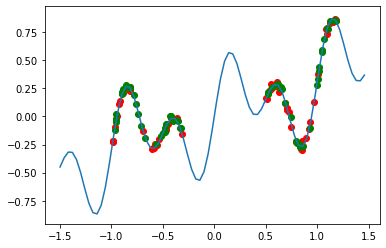

In [5]:
dataset = 'sin'

data_class = ToySinData

x_train, y_train = data_class(use_cache=config['use_cache']).dataset('train')
x_val, y_val = data_class(use_cache=config['use_cache']).dataset('val')
x_true, y_true = data_class().dataset('ground_truth')
    
plt.plot(x_true, y_true)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_val, y_val, color='green')


#### Train model


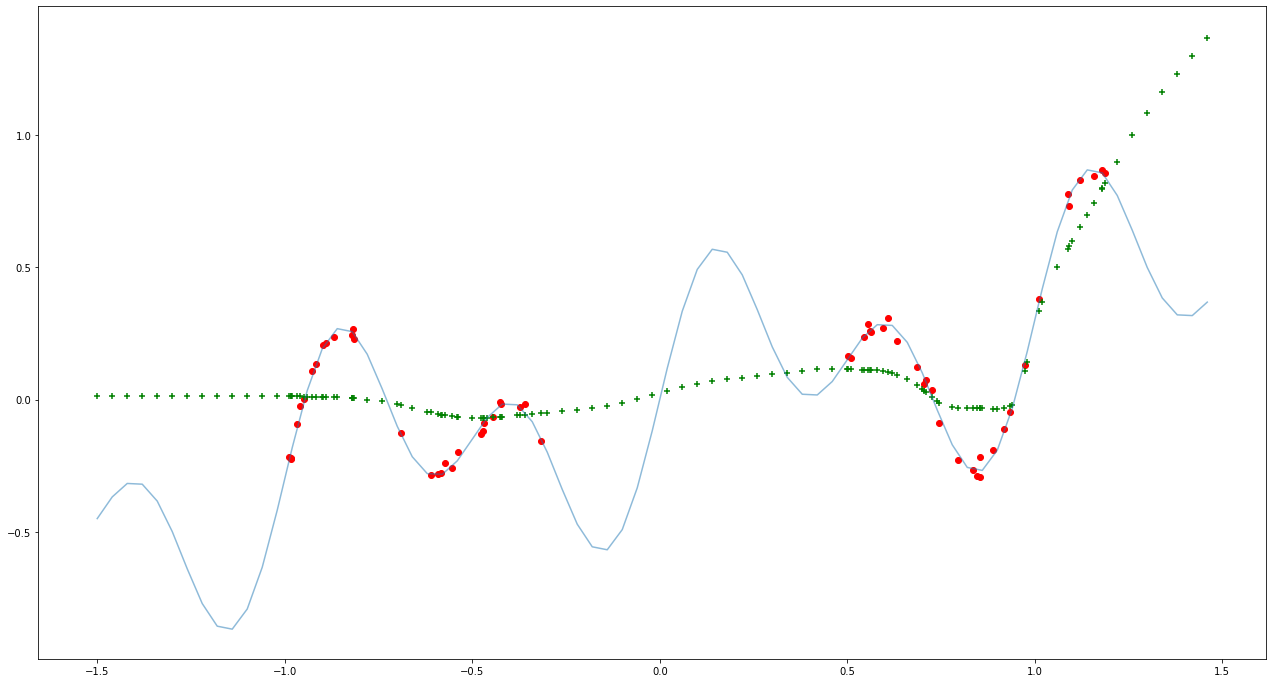

In [6]:
model = Dense(config['layers']).float()

trainer = Trainer(
    model, batch_size=15, dropout_train=config['dropout_train'],
    loss=torch.nn.functional.mse_loss, regression=True)
trainer.fit(
    (x_train, y_train), (x_val, y_val), patience=config['patience'],
     verbose=False, epochs=10000)

x_ = np.concatenate((x_true, x_train))
y_ = trainer.predict(x_)
plt.figure(figsize=(22, 12))
plt.plot(x_true, y_true, alpha=0.5)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_, y_, color='green', marker='+')


In [7]:
masks = build_masks(['basic_bern', 'dpp'])

In [8]:
y_pred = trainer.predict(x_true)

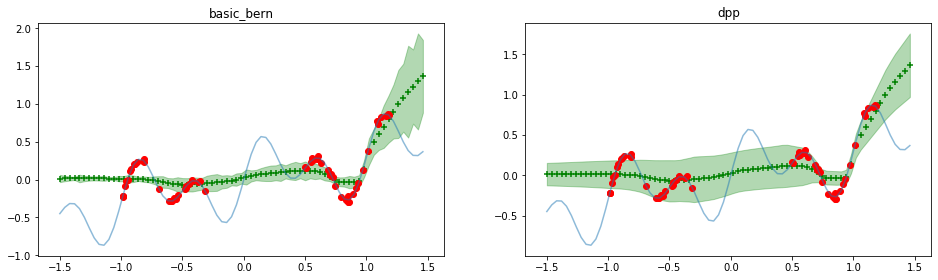

In [9]:
plt.figure(figsize=(16, 30))

def make_uq_graph(name, estimations):
    plt.title(name)
    plt.plot(x_true, y_true, alpha=0.5)
    plt.scatter(x_true, y_pred, color='green', marker='+')
    plt.fill_between(np.ravel(x_true), np.ravel(y_pred)-estimations, np.ravel(y_pred)+estimations, alpha=0.3, color='green')
    plt.scatter(x_train, y_train, color='red')

dropout_runs = {}

for i, (name, mask) in enumerate(masks.items()):
    if hasattr(mask, 'reset'):
        mask.reset()
    trainer.train()
    estimator = build_estimator(
        'mcdue_masked', trainer, keep_runs=True, nn_runs=config['nn_runs'],
        dropout_mask=mask, dropout_rate=config['dropout_uq'])
    
    estimations = estimator.estimate(x_true)
    dropout_runs[name] = estimator.last_mcd_runs()
    plt.subplot(6, 2, i+1)
    make_uq_graph(name, estimations)



### Dropout predictions


In [10]:
def plot_dropout_runs(name, predictions, n=50):
    plt.figure(figsize=(20, 10))
    plt.title(name)
    plt.plot(x_true, y_true)
    plt.scatter(x_train, y_train, color='red')
    for prediction_line in predictions[:n]:
        plt.plot(x_true, prediction_line, alpha=0.5)

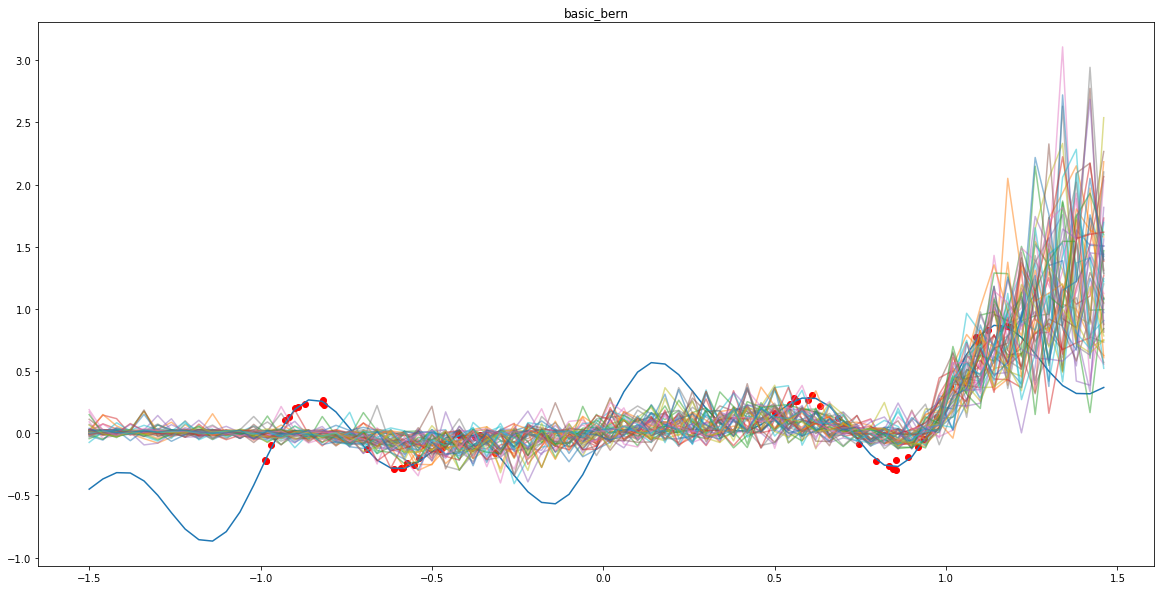

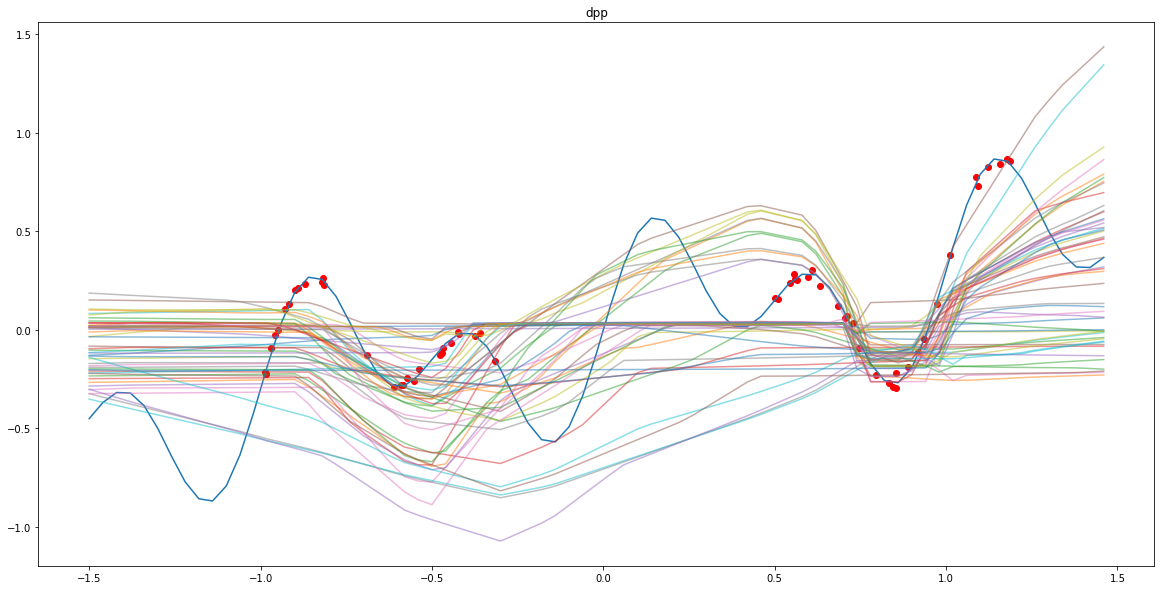

In [11]:
for name, runs in dropout_runs.items():
    plot_dropout_runs(name, runs.T, 200)


In [13]:
dpp = masks['dpp']

In [16]:
samples = dpp.dpps[0].list_of_samples
samples

[array([1, 8, 7, 6]),
 array([ 1, 29, 31, 26, 13,  7]),
 array([29, 13, 31,  5]),
 array([ 8, 21, 20, 22, 18, 26, 12]),
 array([21, 15,  4, 26, 13]),
 array([29, 20, 24,  0, 26, 21]),
 array([ 7,  5, 26, 19, 20, 13]),
 array([ 0,  8, 25, 17]),
 array([16, 13, 12,  1, 29]),
 array([ 4, 17,  3, 13, 31]),
 array([21, 23,  3,  7, 31, 12,  4]),
 array([ 8, 21,  7, 23, 10]),
 array([31, 15, 25, 29, 23]),
 array([21, 18,  9, 20]),
 array([13, 10, 21,  1, 29]),
 array([12,  4, 13, 26,  2, 31]),
 array([30, 25, 10, 12, 24]),
 array([21,  2, 29, 16, 26]),
 array([31, 27, 15, 24]),
 array([13, 26, 22, 25, 17, 15]),
 array([29, 13, 12, 26, 11,  9]),
 array([17,  7, 31,  3, 19]),
 array([20, 12,  9, 26,  7]),
 array([28, 12,  7,  2,  8, 26]),
 array([14,  2, 12, 29, 13]),
 array([ 5,  6,  7, 13]),
 array([31, 18,  4, 26, 20]),
 array([ 8, 21,  7,  6,  1]),
 array([ 8, 25, 28,  2]),
 array([14, 26, 20,  2,  0]),
 array([ 0,  7,  2,  8, 10]),
 array([26, 12, 13, 31, 21,  1,  7]),
 array([ 2, 13, 21, 